In [7]:
from google.colab import auth
auth.authenticate_user()

from google.colab import drive
drive.mount('/content/gdrive', force_remount=False)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# 1. Package load

In [11]:
import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

print('pytorch version: {}'.format(torch.__version__))
print('GPU 사용 가능 여부: {}'.format(torch.cuda.is_available()))
device = "cuda" if torch.cuda.is_available() else "cpu"   # GPU 사용 가능 여부에 따라 device 정보 저장

pytorch version: 1.5.0+cu101
GPU 사용 가능 여부: False


# 2. 하이퍼파라미터 세팅

In [0]:
batch_size = 100
num_epochs = 5
learning_rate = 0.001

# 3. Dataset 및 DataLoader 할당

In [13]:
from torch.utils.data import DataLoader
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=(0.5,), std=(0.5,))])
# MNIST dataset
mnist_train = dsets.MNIST(root='MNIST_data/',
                          train=True,
                          transform=transforms.ToTensor(),
                          download=True)

mnist_test = dsets.MNIST(root='MNIST_data/',
                         train=False,
                         transform=transforms.ToTensor(),
                         download=True)

# dataset loader
train_loader = DataLoader(
    mnist_train,
    batch_size=batch_size,
    shuffle=True,
    drop_last= True
) 

test_loader = DataLoader(
    mnist_test,
    batch_size=batch_size, 
    shuffle=False,
    drop_last= True
)


Extracting MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to MNIST_data/MNIST/raw


Extracting MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST_data/MNIST/raw


Extracting MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST_data/MNIST/raw




Extracting MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST_data/MNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


# 4. 데이터 샘플 시각화

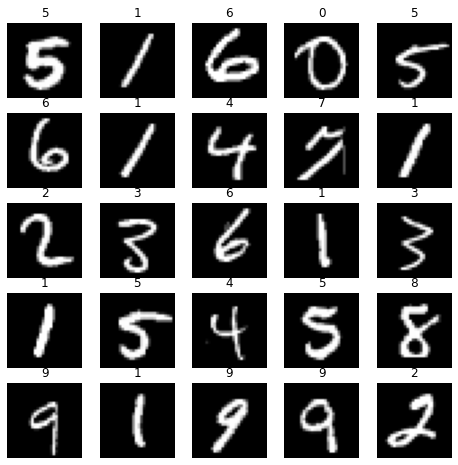

In [17]:
labels_map = {0 : '0', 1 : '1', 2 : '2', 3 : '3', 4 : '4', 5 : '5', 6 : '6',
              7 : '7', 8 : '8', 9 : '9'}
columns = 5
rows = 5
fig = plt.figure(figsize=(8,8))

for i in range(1, columns*rows+1):
    data_idx = np.random.randint(len(mnist_train))
    img = mnist_train[data_idx][0][0,:,:].numpy() # numpy()를 통해 torch Tensor를 numpy array로 변환
    label = labels_map[mnist_train[data_idx][1]] # item()을 통해 torch Tensor를 숫자로 변환
    
    fig.add_subplot(rows, columns, i)
    plt.title(label)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
plt.show()

# 5. 네트워크 설계

In [0]:
linear_layer = nn.Linear(10, 3)
activation_layer = nn.ReLU()

In [19]:
nn.Sequential(
   nn.Linear(10, 3),
   nn.ReLU()
)

Sequential(
  (0): Linear(in_features=10, out_features=3, bias=True)
  (1): ReLU()
)

In [0]:
class DNN(nn.Module):
    def __init__(self, num_classes=10):
        super(DNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Linear(784, 512),    # Linear_1 해당하는 층
            torch.nn.BatchNorm1d(512),    # BatchNorm_1 해당하는 층
            torch.nn.ReLU()    # ReLU_1 해당하는 층
        )
        self.layer2 = nn.Sequential(
            nn.Linear(512,10)    # Linear_2 해당하는 층 
        )
    
    def forward(self, x):
        x = x.view(x.size(0), -1) # flatten
        x_out = self.layer1(x)
        x_out = self.layer2(x_out)
        return x_out

# 6. Weight initialization

In [0]:
def weights_init(m):
    if isinstance(m, nn.Linear): # 모델의 모든 MLP 레이어에 대해서
        nn.init.xavier_normal_(m.weight) # Weight를 xavier_normal로 초기화
        print(m.weight)

# 7. 모델 생성

In [22]:
torch.manual_seed(7777) # 일관된 weight initialization을 위한 random seed 설정
model = DNN().to(device)
model.apply(weights_init) # 모델에 weight_init 함수를 적용하여 weight를 초기화

Parameter containing:
tensor([[-0.0437, -0.0047,  0.0671,  ..., -0.0125, -0.0129, -0.0146],
        [ 0.0727, -0.0370,  0.0367,  ...,  0.0184,  0.0512,  0.0268],
        [-0.0182,  0.0375, -0.0141,  ...,  0.0072, -0.0228,  0.0097],
        ...,
        [-0.0409,  0.0340, -0.0123,  ...,  0.0333,  0.0048,  0.0379],
        [ 0.0204, -0.0544, -0.0059,  ...,  0.0047, -0.0267,  0.0256],
        [ 0.0169,  0.0197, -0.0354,  ...,  0.0029, -0.0067, -0.0555]],
       requires_grad=True)
Parameter containing:
tensor([[-0.0367,  0.0610, -0.1070,  ...,  0.0567,  0.0033,  0.0320],
        [ 0.0578, -0.0620,  0.0097,  ...,  0.0025, -0.0586, -0.0876],
        [-0.0626,  0.0149,  0.0781,  ...,  0.0642, -0.1264, -0.0073],
        ...,
        [ 0.0134,  0.0056,  0.1168,  ...,  0.0135,  0.0050,  0.1229],
        [ 0.0017, -0.0512, -0.0223,  ..., -0.1189,  0.0555, -0.0026],
        [-0.0321, -0.0273,  0.0709,  ..., -0.1396,  0.0144, -0.0953]],
       requires_grad=True)


DNN(
  (layer1): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer2): Sequential(
    (0): Linear(in_features=512, out_features=10, bias=True)
  )
)

# 8. Loss function 및 Optimizer 정의

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# 9. Training

In [24]:
for epoch in range(num_epochs):
    for i, (imgs, labels) in enumerate(train_loader):
        imgs, labels = imgs.to(device), labels.to(device)
                                      
        outputs = model(imgs) 
        loss = criterion(outputs, labels)    
        
        optimizer.zero_grad()          
        loss.backward()          
        optimizer.step()            
        
        _, argmax = torch.max(outputs, 1)
        accuracy = (labels == argmax).float().mean()
        
        if (i+1) % 100 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'.format(
                epoch+1, num_epochs, i+1, len(train_loader), loss.item(), accuracy.item() * 100))

Epoch [1/5], Step [100/600], Loss: 0.1550, Accuracy: 96.00%
Epoch [1/5], Step [200/600], Loss: 0.1894, Accuracy: 97.00%
Epoch [1/5], Step [300/600], Loss: 0.1855, Accuracy: 98.00%
Epoch [1/5], Step [400/600], Loss: 0.1417, Accuracy: 96.00%
Epoch [1/5], Step [500/600], Loss: 0.1225, Accuracy: 95.00%
Epoch [1/5], Step [600/600], Loss: 0.0531, Accuracy: 99.00%
Epoch [2/5], Step [100/600], Loss: 0.0485, Accuracy: 99.00%
Epoch [2/5], Step [200/600], Loss: 0.1503, Accuracy: 97.00%
Epoch [2/5], Step [300/600], Loss: 0.0395, Accuracy: 100.00%
Epoch [2/5], Step [400/600], Loss: 0.0871, Accuracy: 97.00%
Epoch [2/5], Step [500/600], Loss: 0.0462, Accuracy: 99.00%
Epoch [2/5], Step [600/600], Loss: 0.0423, Accuracy: 100.00%
Epoch [3/5], Step [100/600], Loss: 0.0542, Accuracy: 98.00%
Epoch [3/5], Step [200/600], Loss: 0.0832, Accuracy: 97.00%
Epoch [3/5], Step [300/600], Loss: 0.1525, Accuracy: 97.00%
Epoch [3/5], Step [400/600], Loss: 0.0741, Accuracy: 98.00%
Epoch [3/5], Step [500/600], Loss: 0.0

# 10. Test

In [25]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for i, (imgs, labels) in enumerate(test_loader):
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        _, argmax = torch.max(outputs, 1) # max()를 통해 최종 출력이 가장 높은 class 선택
        total += imgs.size(0)
        correct += (labels == argmax).sum().item()
    
    print('Test accuracy for {} images: {:.2f}%'.format(total, correct / total * 100))

Test accuracy for 10000 images: 97.13%


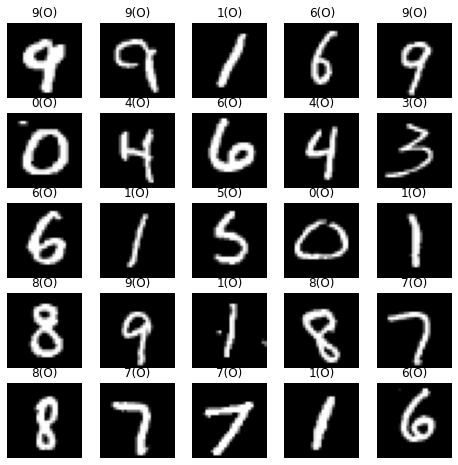

In [26]:
columns = 5
rows = 5
fig = plt.figure(figsize=(8,8))

model.eval()
for i in range(1, columns*rows+1):
    data_idx = np.random.randint(len(mnist_test))
    input_img = mnist_train[data_idx][0].unsqueeze(dim=0).to(device) 
    '''
    unsqueeze()를 통해 입력 이미지의 shape을 (1, 28, 28)에서 (1, 1, 28, 28)로 변환. 
    모델에 들어가는 입력 이미지의 shape은 (batch_size, channel, width, height) 되어야 함에 주의하세요!
    '''
    output = model(input_img)
    _, argmax = torch.max(output, 1)
    pred = labels_map[argmax.item()]
    label = labels_map[mnist_train[data_idx][1]]
    
    fig.add_subplot(rows, columns, i)
    if pred == label:
        plt.title(pred + '(O)')
    else:
        plt.title(pred + '(X)' + ' / ' + label)
    plot_img = mnist_train[data_idx][0][0,:,:]
    plt.imshow(plot_img, cmap='gray')
    plt.axis('off')
model.train()
plt.show()